In [ ]:
# 1. 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

# 2. 압축 파일 복사 (드라이브 -> VM 로컬)
!cp /content/drive/MyDrive/Colab\ Notebooks/data/dataset.zip /content/

# 3. 압축 해제
!unzip -q /content/dataset.zip -d /content/dataset

# 4. 파일 개수 확인 (검수)
import os
pos_count = len(os.listdir('/content/dataset/class_1_sneeze'))
neg_count = len(os.listdir('/content/dataset/class_0_noise'))
print(f"Positive samples: {pos_count}")
print(f"Negative samples: {neg_count}")

In [9]:
import os
import numpy as np
import librosa
from tqdm import tqdm

class SneezeFeatureExtractor:
    def __init__(self, sr=16000, n_mfcc=20, duration=2.0):
        self.sr = sr
        self.n_mfcc = n_mfcc
        self.num_samples = int(sr * duration)

    def extract(self, file_path):
        try:
            # 리샘플링 및 로드
            y, _ = librosa.load(file_path, sr=self.sr, duration=2.0, res_type='scipy')
            
            # 길이 보정
            if len(y) < self.num_samples:
                y = np.pad(y, (0, self.num_samples - len(y)))
            else:
                y = y[:self.num_samples]
            
            # MFCC 변환
            # 결과물 차원: (n_mfcc, time_steps) -> 약 (20, 63)
            mfcc = librosa.feature.mfcc(y=y, sr=self.sr, n_mfcc=self.n_mfcc, hop_length=512)
            return mfcc
        except Exception:
            return None

    def create_dataset(self, root_dir):
        X = []
        y = []
        categories = {'class_0_noise': 0, 'class_1_sneeze': 1}
        
        for cat_name, label in categories.items():
            cat_path = os.path.join(root_dir, cat_name)
            if not os.path.exists(cat_path):
                continue
            
            files = [f for f in os.listdir(cat_path) if f.endswith('.wav')]
            for f in tqdm(files, desc=f"Extracting {cat_name}"):
                feat = self.extract(os.path.join(cat_path, f))
                if feat is not None:
                    X.append(feat)
                    y.append(label)
        
        return np.array(X), np.array(y)

# 1. 추출 인스턴스 생성 및 실행
extractor = SneezeFeatureExtractor()
X_data, y_data = extractor.create_dataset('/content/dataset')

# 2. 결과물 규격 검수
print(f"\n[추출 완료]")
print(f"X 차원 (샘플 수, 특징, 시간): {X_data.shape}")
print(f"y 차원 (라벨 수): {y_data.shape}")

# 3. 구글 드라이브에 직접 저장 (세션 종료 대비)
# 경로가 MyDrive 바로 아래가 아니라면 수정하십시오.
np.save('/content/drive/MyDrive/X_sneeze_features.npy', X_data)
np.save('/content/drive/MyDrive/y_sneeze_labels.npy', y_data)
print("구글 드라이브 저장 성공: X_sneeze_features.npy, y_sneeze_labels.npy")

Extracting class_1_sneeze: 100%|██████████| 10080/10080 [02:04<00:00, 81.03it/s] 



[추출 완료]
X 차원 (샘플 수, 특징, 시간): (25200, 20, 63)
y 차원 (라벨 수): (25200,)
구글 드라이브 저장 성공: X_sneeze_features.npy, y_sneeze_labels.npy


In [10]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. 데이터 로드
X = np.load('/content/drive/MyDrive/X_sneeze_features.npy')
y = np.load('/content/drive/MyDrive/y_sneeze_labels.npy')

# 2. 채널 차원 추가 (Conv2D 입력을 위해 (20, 63, 1) 형태로 변환)
X = X[..., np.newaxis]

# 3. 데이터 분할 (8:1:1)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (20160, 20, 63, 1), Val: (2520, 20, 63, 1), Test: (2520, 20, 63, 1)


In [11]:
# 4. 스케일링 (2D로 펼쳐서 적용 후 다시 복원)
scaler = StandardScaler()
num_train, n_mfcc, n_time, n_chan = X_train.shape

X_train_reshaped = X_train.reshape(num_train, -1)
X_train_scaled = scaler.fit_transform(X_train_reshaped).reshape(num_train, n_mfcc, n_time, n_chan)

X_val_scaled = scaler.transform(X_val.reshape(len(X_val), -1)).reshape(len(X_val), n_mfcc, n_time, n_chan)
X_test_scaled = scaler.transform(X_test.reshape(len(X_test), -1)).reshape(len(X_test), n_mfcc, n_time, n_chan)

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_ds_crnn(input_shape):
    model = models.Sequential()

    # 1. Depthwise Separable Convolution Layer
    model.add(layers.Input(shape=input_shape))
    model.add(layers.SeparableConv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.SeparableConv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # 2. Reshape for RNN (Time distributed features)
    # MaxPooling 후의 형태에 따라 조정 필요
    model.add(layers.Reshape((-1, 64))) 

    # 3. Recurrent Layer (GRU)
    model.add(layers.GRU(64, return_sequences=False))
    model.add(layers.Dropout(0.3))

    # 4. Dense Layer (Output)
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid')) # 이진 분류

    return model

input_shape = (20, 63, 1)
model = build_ds_crnn(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ separable_conv2d                │ (None, 20, 63, 32)     │            73 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 20, 63, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 10, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 10, 31, 64)     │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 10, 31, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 15, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 75, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,930 (116.91 KB)

 Trainable params: 29,738 (116.16 KB)

 Non-trainable params: 192 (768.00 B)

In [14]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stop]
)

Epoch 1/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 69s 205ms/step - accuracy: 0.6323 - loss: 0.6249 - val_accuracy: 0.6016 - val_loss: 1.1414
Epoch 2/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 81s 201ms/step - accuracy: 0.8282 - loss: 0.3791 - val_accuracy: 0.8698 - val_loss: 0.3140
Epoch 3/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 87s 219ms/step - accuracy: 0.8780 - loss: 0.2898 - val_accuracy: 0.8881 - val_loss: 0.2760
Epoch 4/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 63s 200ms/step - accuracy: 0.9134 - loss: 0.2181 - val_accuracy: 0.9159 - val_loss: 0.2042
Epoch 5/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 63s 201ms/step - accuracy: 0.9283 - loss: 0.1894 - val_accuracy: 0.9202 - val_loss: 0.2236
Epoch 6/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 62s 196ms/step - accuracy: 0.9395 - loss: 0.1589 - val_accuracy: 0.9385 - val_loss: 0.1692
Epoch 7/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 83s 199ms/step - accuracy: 0.9506 - loss: 0.1354 - val_accuracy: 0.9357 - val_loss: 0.1769
Epoch 8/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 64s 202ms/step - accuracy: 0.9604 -

In [15]:
test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=2)
print(f"최종 테스트 정확도: {test_acc:.4f}")

79/79 - 2s - 25ms/step - accuracy: 0.9563 - loss: 0.1509
최종 테스트 정확도: 0.9563


In [ ]:
y_test.shape

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step


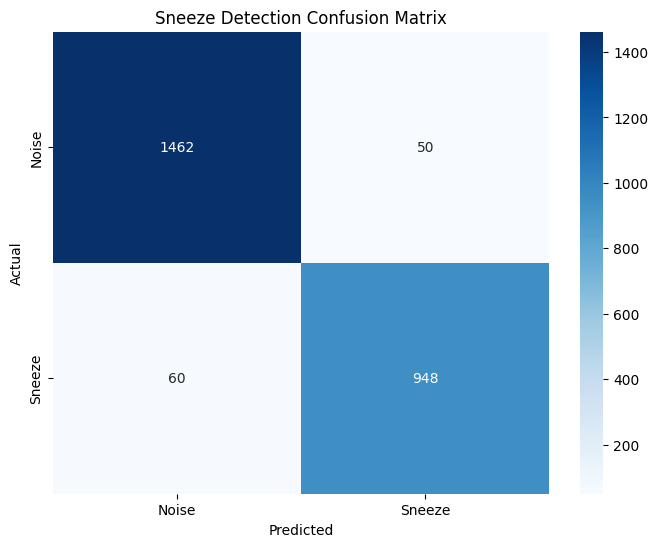

              precision    recall  f1-score   support

       Noise       0.96      0.97      0.96      1512
      Sneeze       0.95      0.94      0.95      1008

    accuracy                           0.96      2520
   macro avg       0.96      0.95      0.95      2520
weighted avg       0.96      0.96      0.96      2520



In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 예측값 생성
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

# 2. 혼동 행렬 계산
cm = confusion_matrix(y_test, y_pred)

# 3. 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Noise', 'Sneeze'], 
            yticklabels=['Noise', 'Sneeze'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Sneeze Detection Confusion Matrix')
plt.show()

# 4. 세부 지표 출력
print(classification_report(y_test, y_pred, target_names=['Noise', 'Sneeze']))

In [19]:
model.save('sneeze_detection_model.keras')

In [25]:
!cp sneeze_detection_model.keras /content/drive/MyDrive/

In [26]:
import joblib

# 학습 세션에서 실행하여 드라이브에 저장
joblib.dump(scaler, '/content/drive/MyDrive/sneeze_scaler.pkl')

['/content/drive/MyDrive/sneeze_scaler.pkl']

In [27]:
import numpy as np
import librosa
import tensorflow as tf
import joblib
import time

class RealTimeSneezeDetector:
    def __init__(self, model_path, scaler_path):
        self.model = tf.keras.models.load_model(model_path)
        self.scaler = joblib.load(scaler_path)
        self.sr = 16000
        self.n_mfcc = 20
        self.duration = 2.0
        self.threshold = 0.5 # 필요 시 0.7 등으로 상향 조절

    def preprocess(self, audio_data):
        # 1. MFCC 추출
        mfcc = librosa.feature.mfcc(y=audio_data, sr=self.sr, n_mfcc=self.n_mfcc, hop_length=512)
        
        # 2. 스케일링 (2D -> 1D 변환 후 적용)
        feat_reshaped = mfcc.reshape(1, -1)
        feat_scaled = self.scaler.transform(feat_reshaped)
        
        # 3. 모델 입력 차원으로 재구성 (batch, height, width, channel)
        return feat_scaled.reshape(1, 20, 63, 1)

    def predict(self, audio_data):
        input_tensor = self.preprocess(audio_data)
        prediction = self.model.predict(input_tensor, verbose=0)[0][0]
        return prediction

# 엔진 초기화
detector = RealTimeSneezeDetector('sneeze_detection_model.keras', '/content/drive/MyDrive/sneeze_scaler.pkl')

In [28]:
import random

# 테스트 셋에서 랜덤 샘플 추출
idx = random.randint(0, len(X_test) - 1)
test_sample_mfcc = X_test[idx] # 이미 MFCC로 변환된 상태라고 가정
true_label = y_test[idx]

# 추론 수행
# 시뮬레이션을 위해 MFCC를 다시 스케일링하고 예측하는 로직 실행
feat_reshaped = test_sample_mfcc.reshape(1, -1)
feat_scaled = detector.scaler.transform(feat_reshaped)
final_input = feat_scaled.reshape(1, 20, 63, 1)

prob = detector.model.predict(final_input, verbose=0)[0][0]
result = "SNEEZE" if prob > detector.threshold else "NOISE"

print(f"--- 실시간 테스트 결과 ---")
print(f"예측 결과: {result} (확률: {prob:.4f})")
print(f"실제 정답: {'SNEEZE' if true_label == 1 else 'NOISE'}")

--- 실시간 테스트 결과 ---
예측 결과: SNEEZE (확률: 0.9999)
실제 정답: SNEEZE
